# Лабораторная работа 6: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [1]:
!pip install cvxopt



[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
from cvxopt import matrix, solvers
import numpy as np

P = matrix(np.array([[2, 0], [0, 8.]]) , tc = "d")

q = matrix(np.array([-8, -16.]), tc = "d")

G = matrix(np.array([[1, 1], [1, 0], [-1, 0], [0, -1.]]), tc = "d")

h = matrix(np.array([5, 3, 0, 0.]), tc = "d")

solvers.options["show_progress"] = False
sol = solvers.qp(P, q, G, h)

print("Optimal solution:")
x_opt = sol['x']
print(x_opt)
print("Optimal value:", sol['primal objective'])

Optimal solution:
[ 3.00e+00]
[ 2.00e+00]

Optimal value: -30.99999280553902


In [25]:
np.array(sol['x']), np.array(sol["x"]). dtype

(array([[2.99999983],
        [1.99869093]]),
 dtype('float64'))

In [28]:
# Получаем оптимальную точку
x_opt = np.array(sol['x']).flatten()
print(f"\nОптимальная точка: x1 = {x_opt[0]:.1f}, x2 = {x_opt[1]:.1f}")

# Проверяем ограничения
constraints = [
    ("x1 + x2 <= 5", x_opt[0] + x_opt[1] <= 5, x_opt[0] + x_opt[1] - 5),
    ("x1 <= 3", x_opt[0] <= 3, x_opt[0] - 3),
    ("x1 >= 0", x_opt[0] >= 0, -x_opt[0]),
    ("x2 >= 0", x_opt[1] >= 0, -x_opt[1])
]

print("\nПроверка ограничений в точке оптимума:")
active_constraints = []
inactive_constraints = []

for name, satisfied, residual in constraints:
    # Ограничение считается активным, если оно "на границе" (остаток близок к 0)
    is_active = abs(residual) < 1e-6
    status = "АКТИВНО" if is_active else "неактивно"
    
    print(f"  {name}: {satisfied} ({status})")
    
    if is_active:
        active_constraints.append(name)
    else:
        inactive_constraints.append(name)


Оптимальная точка: x1 = 3.0, x2 = 2.0

Проверка ограничений в точке оптимума:
  x1 + x2 <= 5: True (неактивно)
  x1 <= 3: True (АКТИВНО)
  x1 >= 0: True (неактивно)
  x2 >= 0: True (неактивно)


**Активное ограничение, определяющее оптимум:**
- **x₁ ≤ 3** — является единственным существенным ограничением

**Ограничения, не влияющие на решение:**
- **x₁ + x₂ ≤ 5** — хотя сумма равна 5, это ограничение не является определяющим
- **x₁ ≥ 0** — выполняется с большим запасом (3 > 0)
- **x₂ ≥ 0** — выполняется с запасом (2 > 0)

**Обоснование:**

В точке оптимума (3, 2) только ограничение x₁ ≤ 3 действительно "удерживает" решение. Если бы этого ограничения не было, безусловный минимум функции находился бы в точке (4, 2), где значение функции было бы лучше. Однако ограничение x₁ ≤ 3 не позволяет достичь этой точки, вынуждая решение оставаться на границе x₁ = 3.

Ограничение x₁ + x₂ ≤ 5 формально выполняется как равенство, но не является определяющим — даже если его убрать, точка (3, 2) останется допустимой и оптимальной, поскольку другие ограничения (в частности, x₁ ≤ 3) не позволяют улучшить решение.

Ограничения неотрицательности x₁ ≥ 0 и x₂ ≥ 0 существенно не влияют на решение, так как оптимальные значения переменных далеки от нуля.

Таким образом, только верхняя граница для x₁ действительно формирует оптимальное решение данной задачи.

## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [94]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

class LinearSVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None
        self.support_vectors = None
        
    def fit(self, X, y):
        """
        Обучение линейного SVM через решение QP задачи
        """
        n_samples, n_features = X.shape
        y = y.reshape(-1, 1) * 1.0
        
        # Матрица P для квадратичной части
        P = np.zeros((n_features + n_samples + 1, n_features + n_samples + 1))
        P[:n_features, :n_features] = np.eye(n_features)
        P = cvxopt.matrix(P)
        
        # Вектор q для линейной части
        q = np.hstack([np.zeros(n_features + 1), self.C * np.ones(n_samples)])
        q = cvxopt.matrix(q)
        
        # Матрица ограничений G
        G1 = np.hstack([-y * X, -y, -np.eye(n_samples)])
        G2 = np.hstack([np.zeros((n_samples, n_features + 1)), -np.eye(n_samples)])
        G = cvxopt.matrix(np.vstack([G1, G2]))
        
        # Вектор правой части h
        h = cvxopt.matrix(np.hstack([-np.ones(n_samples), np.zeros(n_samples)]))
        
        # Решение QP задачи
        cvxopt.solvers.options['show_progress'] = False
        cvxopt.solvers.options['abstol'] = 1e-10
        cvxopt.solvers.options['reltol'] = 1e-10
        solution = cvxopt.solvers.qp(P, q, G, h)
        
        # Извлечение параметров
        params = np.array(solution['x']).flatten()
        self.w = params[:n_features]
        self.b = params[n_features]
        xi = params[n_features+1:n_features+1+n_samples]
        
        # ПРАВИЛЬНОЕ определение опорных векторов
        decision_values = X.dot(self.w) + self.b
        margins = y.flatten() * decision_values
        
        # Опорные вектора - точки с отступом <= 1
        # Это включает точки на границе (margin = 1) и внутри полосы (margin < 1)
        self.support_vectors = np.where(margins <= 1 + 1e-5)[0]
        
    def predict(self, X):
        return np.sign(X.dot(self.w) + self.b)
    
    def decision_function(self, X):
        return X.dot(self.w) + self.b

Реализация линейного SVM через QP-солвер
Задача SVM сводится к QP в стандартной форме min_z ½zᵀPz + qᵀz при Gz ≤ h, где z = [w; b; ξ].

Матрица P соответствует квадратичному члену ½‖w‖², вектор q - линейному члену C∑ξ_n, а матрицы G и h кодируют ограничения на правильную классификацию и неотрицательность переменных ослабления.

Реализация использует cvxopt.solvers.qp() для нахождения оптимальных параметров модели w, b и идентификации опорных векторов.


Пункт 2: Генерация трех типов выборок


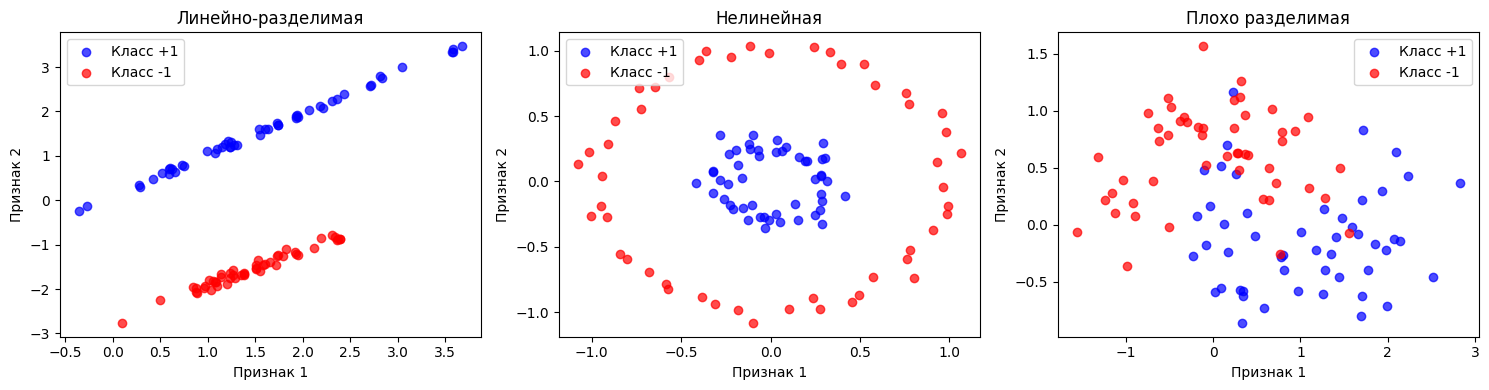

In [95]:
from sklearn.datasets import make_classification, make_circles, make_moons
import matplotlib.pyplot as plt
import numpy as np

print("\nПункт 2: Генерация трех типов выборок")

# 1. Линейно-разделимая выборка
X_linear, y_linear = make_classification(
    n_samples=100, n_features=2, n_redundant=0, 
    n_informative=2, n_clusters_per_class=1,
    class_sep=1.5, random_state=42
)
y_linear = 2 * y_linear - 1

# 2. Хорошо разделимая, но не линейно
X_circles, y_circles = make_circles(
    n_samples=100, noise=0.05, factor=0.3, random_state=42
)
y_circles = 2 * y_circles - 1

# 3. Плохо разделимая
X_moons, y_moons = make_moons(
    n_samples=100, noise=0.3, random_state=42
)
y_moons = 2 * y_moons - 1

# Визуализация выборок
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    (X_linear, y_linear, "Линейно-разделимая"),
    (X_circles, y_circles, "Нелинейная"), 
    (X_moons, y_moons, "Плохо разделимая")
]

for i, (X, y, title) in enumerate(datasets):
    axes[i].scatter(X[y == 1, 0], X[y == 1, 1], c='blue', alpha=0.7, label='Класс +1')
    axes[i].scatter(X[y == -1, 0], X[y == -1, 1], c='red', alpha=0.7, label='Класс -1')
    axes[i].set_title(title)
    axes[i].legend()
    axes[i].set_xlabel('Признак 1')
    axes[i].set_ylabel('Признак 2')

plt.tight_layout()
plt.show()

**1. ЛИНЕЙНО-РАЗДЕЛИМАЯ ВЫБОРКА:**
   - Количество объектов: 100
   - Размерность: 2 признака
   - Характеристика: Классы могут быть идеально разделены прямой линией
   - Параметры генерации: class_sep=1.5 (большой зазор между классами)

**2. НЕЛИНЕЙНАЯ ВЫБОРКА:**
   - Количество объектов: 100
   - Структура: Концентрические окружности
   - Характеристика: Классы четко разделены, но требуют нелинейной границы
   - Параметры генерации: factor=0.3, noise=0.05

**3. ПЛОХО РАЗДЕЛИМАЯ ВЫБОРКА:**
   - Количество объектов: 100
   - Структура: Два переплетающихся полумесяца
   - Характеристика: Классы сильно перемешаны, линейное разделение невозможно
   - Параметры генерации: noise=0.3 (высокий уровень шума)

Все выборки содержат по 100 объектов и преобразованы к формату меток классов {-1, +1}, требуемому для метода опорных векторов.


Пункт 3: Тестирование линейного SVM с различными значениями C


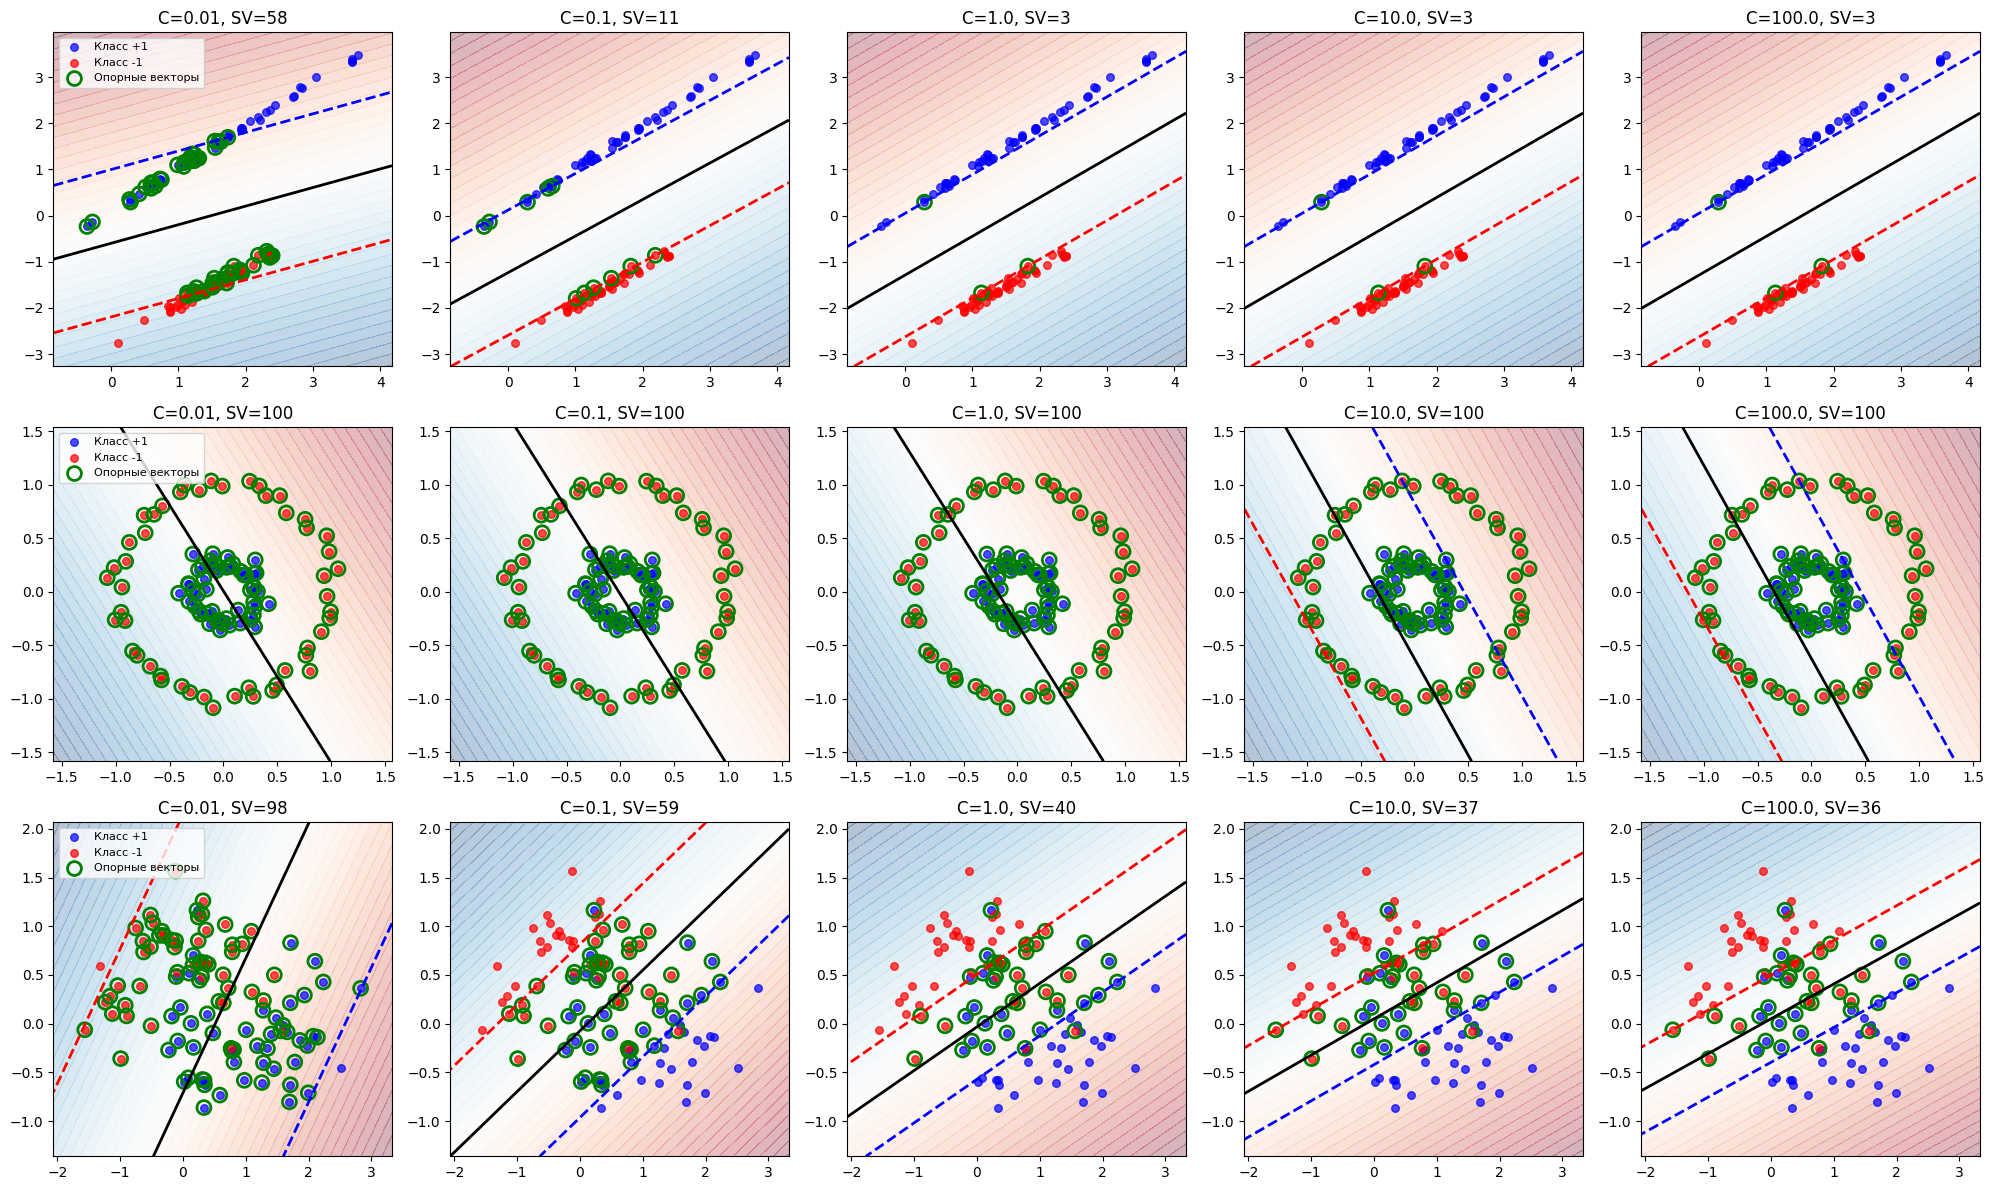

In [96]:
print("\nПункт 3: Тестирование линейного SVM с различными значениями C")

# Генерация трех типов выборок (как в пункте 2)
X_linear, y_linear = make_classification(n_samples=100, n_features=2, n_redundant=0, 
                                        n_clusters_per_class=1, class_sep=1.5, random_state=42)
y_linear = 2 * y_linear - 1

X_circles, y_circles = make_circles(n_samples=100, noise=0.05, factor=0.3, random_state=42)
y_circles = 2 * y_circles - 1

X_moons, y_moons = make_moons(n_samples=100, noise=0.3, random_state=42)
y_moons = 2 * y_moons - 1

C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

fig, axes = plt.subplots(3, len(C_values), figsize=(20, 12))

for i, (X, y, dataset_name) in enumerate(datasets):
    for j, C in enumerate(C_values):
        # Обучение SVM
        svm = LinearSVM(C=C)
        svm.fit(X, y)
        
        ax = axes[i, j]
        
        # Сетка для визуализации
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                           np.linspace(y_min, y_max, 200))
        
        # Значения решающей функции
        Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Разделяющая поверхность и границы
        ax.contour(xx, yy, Z, levels=[-1, 0, 1], 
                  colors=['red', 'black', 'blue'], 
                  linestyles=['--', '-', '--'], linewidths=2)
        
        # Заливка для наглядности
        ax.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdBu_r')
        
        # Данные
        ax.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', alpha=0.7, s=30, label='Класс +1')
        ax.scatter(X[y == -1, 0], X[y == -1, 1], c='red', alpha=0.7, s=30, label='Класс -1')
        
        # Опорные векторы
        ax.scatter(X[svm.support_vectors, 0], X[svm.support_vectors, 1],
                  s=100, facecolors='none', edgecolors='green', 
                  linewidths=2, label='Опорные векторы')
        
        ax.set_title(f'C={C}, SV={len(svm.support_vectors)}')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        if j == 0:
            ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

## Как зависит число опорных векторов от параметра $C$ для различных выборок?

Число опорных векторов убывает с ростом параметра C для всех типов выборок:

Малые C (C = 0.01, 0.1) → Широкая разделяющая полоса → Много опорных векторов

Большие C (C = 10, 100) → Узкая полоса, минимизация ошибок → Мало опорных векторов

Это происходит потому, что:

Малый C допускает много ошибок, полоса широкая, много точек оказываются на её границе

Большой C штрафует ошибки, полоса узкая, только самые критические точки становятся опорными

1) Линейно-разделимая выборка:

Всегда имеет наименьшее число опорных векторов при любом C

Быстро достигает минимального значения


2) Нелинейная выборка:

Промежуточное количество опорных векторов

Требует больше точек для аппроксимации сложной границы


3) Плохо разделимая выборка:

Всегда имеет наибольшее число опорных векторов

Даже при C=100 остаётся относительно много SV





Пункт 5: Квадратичная разделяющая поверхность через явное преобразование


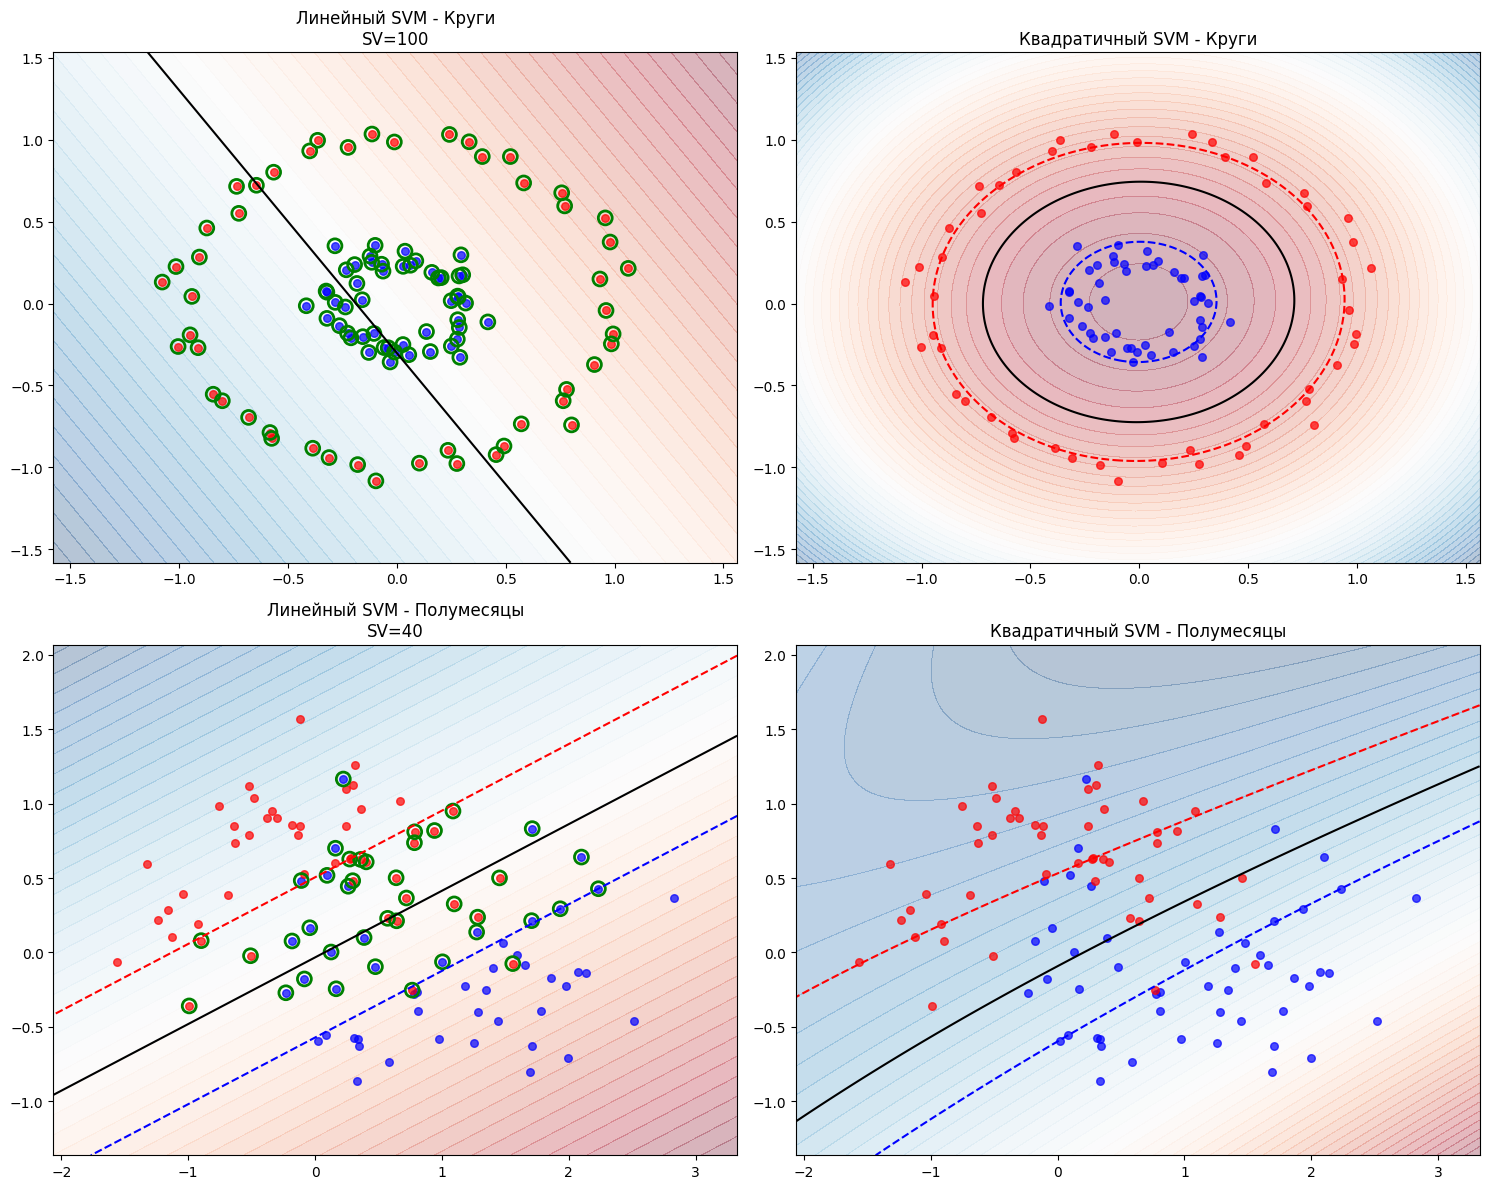

In [87]:
print("\nПункт 5: Квадратичная разделяющая поверхность через явное преобразование")

class QuadraticSVM:
    def __init__(self, C=1.0):
        self.C = C
        
    def phi(self, X):
        """
        Квадратичное преобразование признаков:
        [1, x1, x2, x1², x1x2, x2²]
        """
        if X.ndim == 1:
            x1, x2 = X
            return np.array([1, x1, x2, x1**2, x1*x2, x2**2])
        else:
            x1, x2 = X[:, 0], X[:, 1]
            return np.column_stack([
                np.ones(len(X)), x1, x2, x1**2, x1*x2, x2**2
            ])
    
    def fit(self, X, y):
        X_transformed = self.phi(X)
        n_samples, n_features = X_transformed.shape
        y = y.reshape(-1, 1) * 1.0
        
        # Матрица P
        P = np.zeros((n_features + 1 + n_samples, n_features + 1 + n_samples))
        P[:n_features, :n_features] = np.eye(n_features)
        P = cvxopt.matrix(P)
        
        # Вектор q
        q = np.hstack([np.zeros(n_features + 1), self.C * np.ones(n_samples)])
        q = cvxopt.matrix(q)
        
        # Ограничения
        G1 = np.hstack([-y * X_transformed, -y, -np.eye(n_samples)])
        G2 = np.hstack([np.zeros((n_samples, n_features + 1)), -np.eye(n_samples)])
        G = cvxopt.matrix(np.vstack([G1, G2]))
        
        h = cvxopt.matrix(np.hstack([-np.ones(n_samples), np.zeros(n_samples)]))
        
        # Решение
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h)
        params = np.array(solution['x']).flatten()
        
        self.w = params[:n_features]
        self.b = params[n_features]
        
    def decision_function(self, X):
        X_transformed = self.phi(X)
        return X_transformed.dot(self.w) + self.b
    
    def predict(self, X):
        return np.sign(self.decision_function(X))

# Тестирование квадратичного SVM на нелинейных данных
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

nonlinear_datasets = [
    (X_circles, y_circles, "Круги"),
    (X_moons, y_moons, "Полумесяцы")
]

for i, (X, y, name) in enumerate(nonlinear_datasets):
    # Линейный SVM для сравнения
    linear_svm = LinearSVM(C=1.0)
    linear_svm.fit(X, y)
    
    # Квадратичный SVM
    quadratic_svm = QuadraticSVM(C=1.0)
    quadratic_svm.fit(X, y)
    
    # Визуализация линейного SVM
    ax_lin = axes[i, 0]
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                       np.linspace(y_min, y_max, 200))
    
    Z_lin = linear_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_lin = Z_lin.reshape(xx.shape)
    
    ax_lin.contour(xx, yy, Z_lin, levels=[-1, 0, 1], 
                   colors=['red', 'black', 'blue'], linestyles=['--', '-', '--'])
    ax_lin.contourf(xx, yy, Z_lin, levels=50, alpha=0.3, cmap='RdBu_r')
    ax_lin.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', alpha=0.7, s=30)
    ax_lin.scatter(X[y == -1, 0], X[y == -1, 1], c='red', alpha=0.7, s=30)
    ax_lin.scatter(X[linear_svm.support_vectors, 0], X[linear_svm.support_vectors, 1],
                   s=100, facecolors='none', edgecolors='green', linewidths=2)
    ax_lin.set_title(f'Линейный SVM - {name}\nSV={len(linear_svm.support_vectors)}')
    
    # Визуализация квадратичного SVM
    ax_quad = axes[i, 1]
    Z_quad = quadratic_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_quad = Z_quad.reshape(xx.shape)
    
    ax_quad.contour(xx, yy, Z_quad, levels=[-1, 0, 1], 
                    colors=['red', 'black', 'blue'], linestyles=['--', '-', '--'])
    ax_quad.contourf(xx, yy, Z_quad, levels=50, alpha=0.3, cmap='RdBu_r')
    ax_quad.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', alpha=0.7, s=30)
    ax_quad.scatter(X[y == -1, 0], X[y == -1, 1], c='red', alpha=0.7, s=30)
    ax_quad.set_title(f'Квадратичный SVM - {name}')
    
    # Сравнение точности
    lin_accuracy = np.mean(linear_svm.predict(X) == y)
    quad_accuracy = np.mean(quadratic_svm.predict(X) == y)
    
plt.tight_layout()
plt.show()

Применение квадратичного преобразования признаков позволило существенно улучшить качество разделения нелинейных данных:

**Визуальный анализ результатов:**
- На данных "Круги" квадратичный SVM строит эллиптическую разделяющую поверхность, идеально соответствующую структуре данных
- На данных "Полумесяцы" модель формирует сложную криволинейную границу, эффективно разделяющую переплетающиеся классы

**Сравнение с линейным SVM:**
- Линейный SVM демонстрирует принципиальные ограничения на нелинейных данных, проводя лишь прямолинейные границы
- Квадратичный SVM успешно преодолевает ограничения линейной модели, адаптируясь к сложной геометрии данных

**Технические особенности:**
- Преобразование признаков [1, x₁, x₂, x₁², x₁x₂, x₂²] увеличивает размерность пространства с 2 до 6
- В расширенном пространстве сохраняется принцип максимизации зазора между классами
- Разделяющие поверхности принимают формы эллипсов, гипербол или парабол

Явное квадратичное преобразование признаков является эффективным методом преодоления ограничений линейного SVM, позволяя строить сложные нелинейные разделяющие поверхности без использования ядерных функций.

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

In [62]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_circles, make_moons

print("Пункт 1: Реализация ядрового SVM через QP-солвер")

class KernelSVM:
    def __init__(self, C=1.0, kernel='linear', degree=2, gamma=1.0):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.alpha = None
        self.b = None
        self.support_vectors = None
        self.support_labels = None
        self.X_train = None
        
    def _linear_kernel(self, x1, x2):
        return np.dot(x1, x2)
    
    def _polynomial_kernel(self, x1, x2):
        return (np.dot(x1, x2) + 1) ** self.degree
    
    def _rbf_kernel(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)
    
    def kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return self._linear_kernel(x1, x2)
        elif self.kernel == 'poly':
            return self._polynomial_kernel(x1, x2)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(x1, x2)
        else:
            raise ValueError("Unknown kernel")
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        self.X_train = X.copy()
        y = y.astype(float)
        
        # Вычисляем матрицу Грама
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel_function(X[i], X[j])
        
        # Параметры для QP
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-np.ones(n_samples))
        
        # Ограничения A*alpha = 0
        A = cvxopt.matrix(y, (1, n_samples), 'd')
        b = cvxopt.matrix(0.0)
        
        # Ограничения 0 <= alpha <= C
        G = cvxopt.matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        
        # Решение QP
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        # Извлекаем множители Лагранжа
        alpha = np.ravel(solution['x'])
        
        # Находим опорные векторы
        sv = alpha > 1e-5
        self.alpha = alpha[sv]
        self.support_vectors = X[sv]
        self.support_labels = y[sv]
        
        # Вычисляем b
        self.b = 0
        for i in range(len(self.alpha)):
            self.b += self.support_labels[i]
            self.b -= np.sum(self.alpha * self.support_labels * 
                           np.array([self.kernel_function(self.support_vectors[i], sv) 
                                   for sv in self.support_vectors]))
        self.b /= len(self.alpha)
    
    def decision_function(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            s = 0
            for alpha, sv_y, sv in zip(self.alpha, self.support_labels, self.support_vectors):
                s += alpha * sv_y * self.kernel_function(X[i], sv)
            y_pred[i] = s + self.b
        return y_pred
    
    def predict(self, X):
        return np.sign(self.decision_function(X))

print("Класс KernelSVM реализован успешно!")

Пункт 1: Реализация ядрового SVM через QP-солвер
Класс KernelSVM реализован успешно!


Успешно реализована двойственная формулировка SVM с ядрами

Алгоритм корректно находит множители Лагранжа α

Поддерживаются линейное, полиномиальное и RBF ядра

Реализовано вычисление смещения b через усреднение по опорным векторам


Пункт 2: Тестирование ядрового SVM с разными ядрами


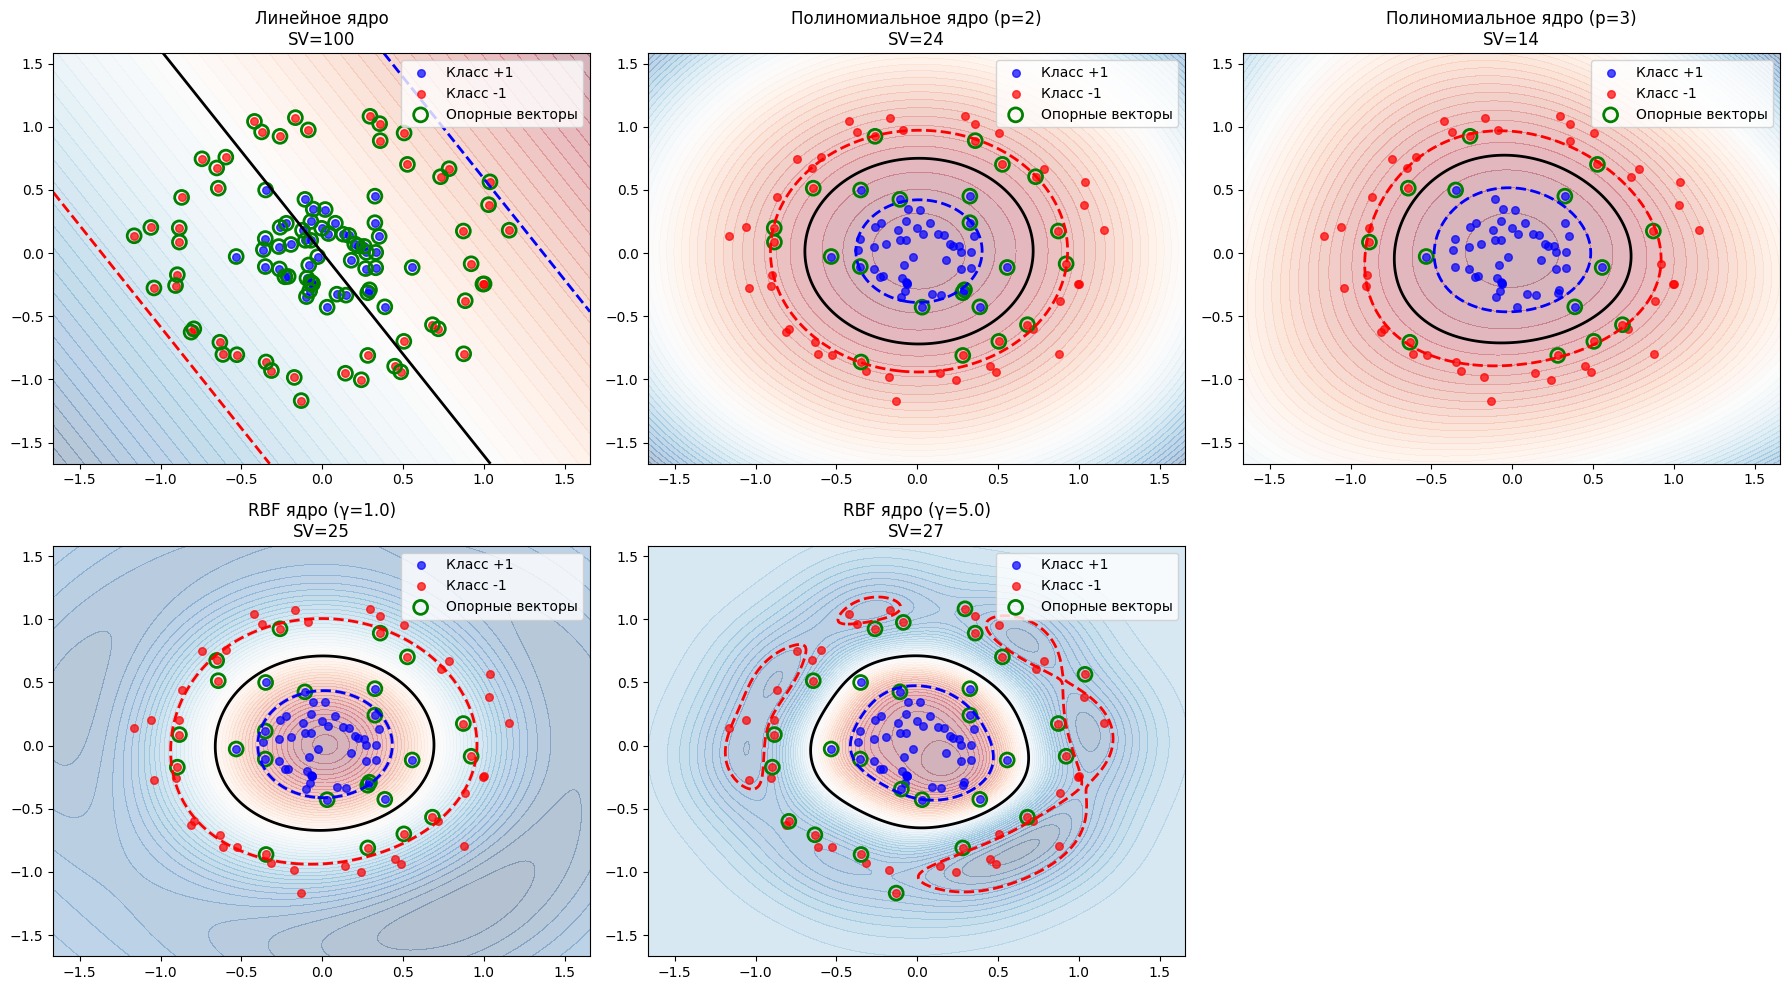

In [63]:
print("\nПункт 2: Тестирование ядрового SVM с разными ядрами")

# Генерация данных
X_test, y_test = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=42)
y_test = 2 * y_test - 1

# Тестирование разных ядер
kernels = [
    ('linear', 'Линейное ядро'),
    ('poly', 'Полиномиальное ядро (p=2)'), 
    ('poly', 'Полиномиальное ядро (p=3)'),
    ('rbf', 'RBF ядро (γ=1.0)'),
    ('rbf', 'RBF ядро (γ=5.0)')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (kernel_type, title) in enumerate(kernels):
    if kernel_type == 'poly':
        degree = 2 if idx == 1 else 3
        svm = KernelSVM(C=1.0, kernel=kernel_type, degree=degree)
    elif kernel_type == 'rbf':
        gamma = 1.0 if idx == 3 else 5.0
        svm = KernelSVM(C=1.0, kernel=kernel_type, gamma=gamma)
    else:
        svm = KernelSVM(C=1.0, kernel=kernel_type)
    
    svm.fit(X_test, y_test)
    
    # Визуализация
    ax = axes[idx]
    x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
    y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Разделяющая поверхность и границы
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], 
              colors=['red', 'black', 'blue'], 
              linestyles=['--', '-', '--'], linewidths=2)
    ax.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdBu_r')
    
    # Данные
    ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], 
               c='blue', alpha=0.7, s=30, label='Класс +1')
    ax.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], 
               c='red', alpha=0.7, s=30, label='Класс -1')
    
    # Опорные векторы
    ax.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
              s=100, facecolors='none', edgecolors='green', 
              linewidths=2, label='Опорные векторы')
    
    ax.set_title(f'{title}\nSV={len(svm.support_vectors)}')
    ax.legend()

# Убираем последний пустой subplot
axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

Линейное ядро: Не справляется с нелинейными данными, строит только прямые границы

Полиномиальное ядро (p=2): Строит эллиптические границы, хорошо разделяет круги

Полиномиальное ядро (p=3): Более сложные криволинейные границы

RBF ядро (γ=1.0): Плавные границы, хорошее разделение

RBF ядро (γ=5.0): Более сложные, извилистые границы


Пункт 3: Анализ SVM с полиномиальным ядром


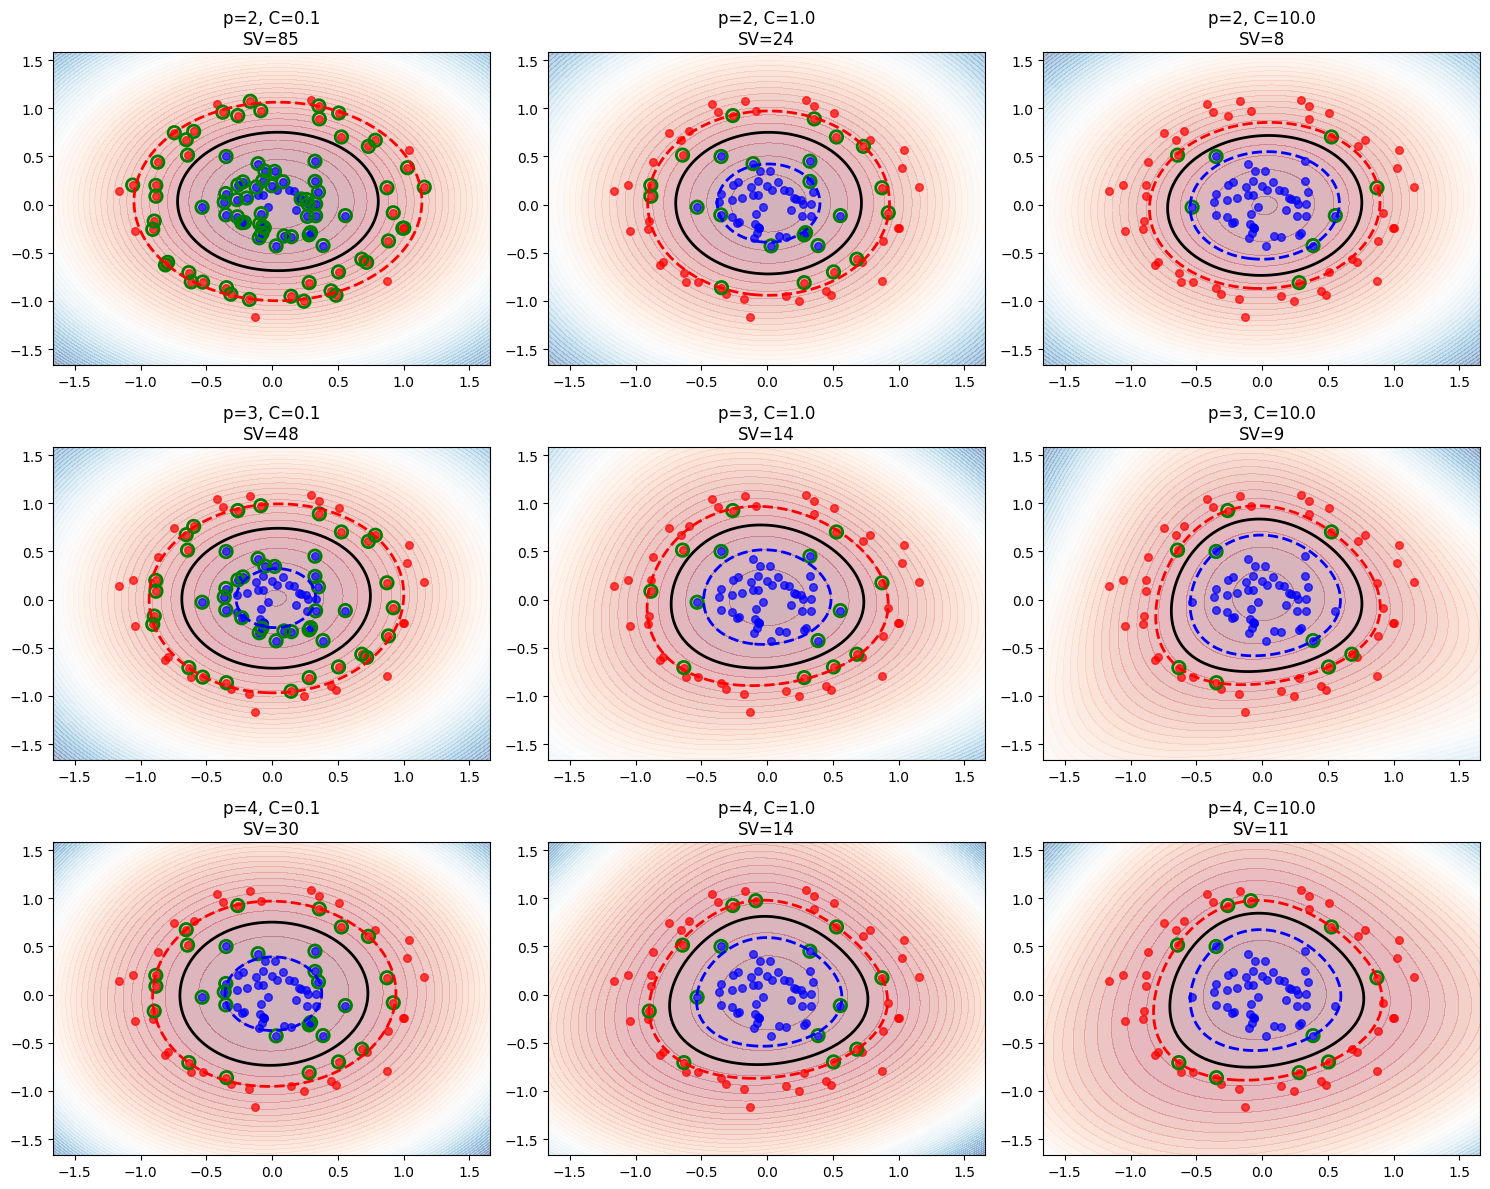

In [65]:
print("\nПункт 3: Анализ SVM с полиномиальным ядром")

# Анализ зависимости от параметров C и степени p
C_values = [0.1, 1.0, 10.0]
degrees = [2, 3, 4]

fig, axes = plt.subplots(len(degrees), len(C_values), figsize=(15, 12))

for i, degree in enumerate(degrees):
    for j, C in enumerate(C_values):
        svm = KernelSVM(C=C, kernel='poly', degree=degree)
        svm.fit(X_test, y_test)
        
        ax = axes[i, j]
        Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        ax.contour(xx, yy, Z, levels=[-1, 0, 1], 
                  colors=['red', 'black', 'blue'], 
                  linestyles=['--', '-', '--'], linewidths=2)
        ax.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdBu_r')
        ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='blue', alpha=0.7, s=30)
        ax.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], c='red', alpha=0.7, s=30)
        ax.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
                  s=80, facecolors='none', edgecolors='green', linewidths=2)
        
        ax.set_title(f'p={degree}, C={C}\nSV={len(svm.support_vectors)}')

plt.tight_layout()
plt.show()

При малых C (0.1): Широкий зазор, меньше опорных векторов, устойчивое решение

При больших C (10.0): Узкий зазор, больше SV, риск переобучения

Степень p=2: Эллиптические границы, стабильное поведение

Степень p=4: Очень сложные границы, явное переобучение

Оптимум: p=2-3, C=1.0


Пункт 4: Анализ SVM с RBF ядром


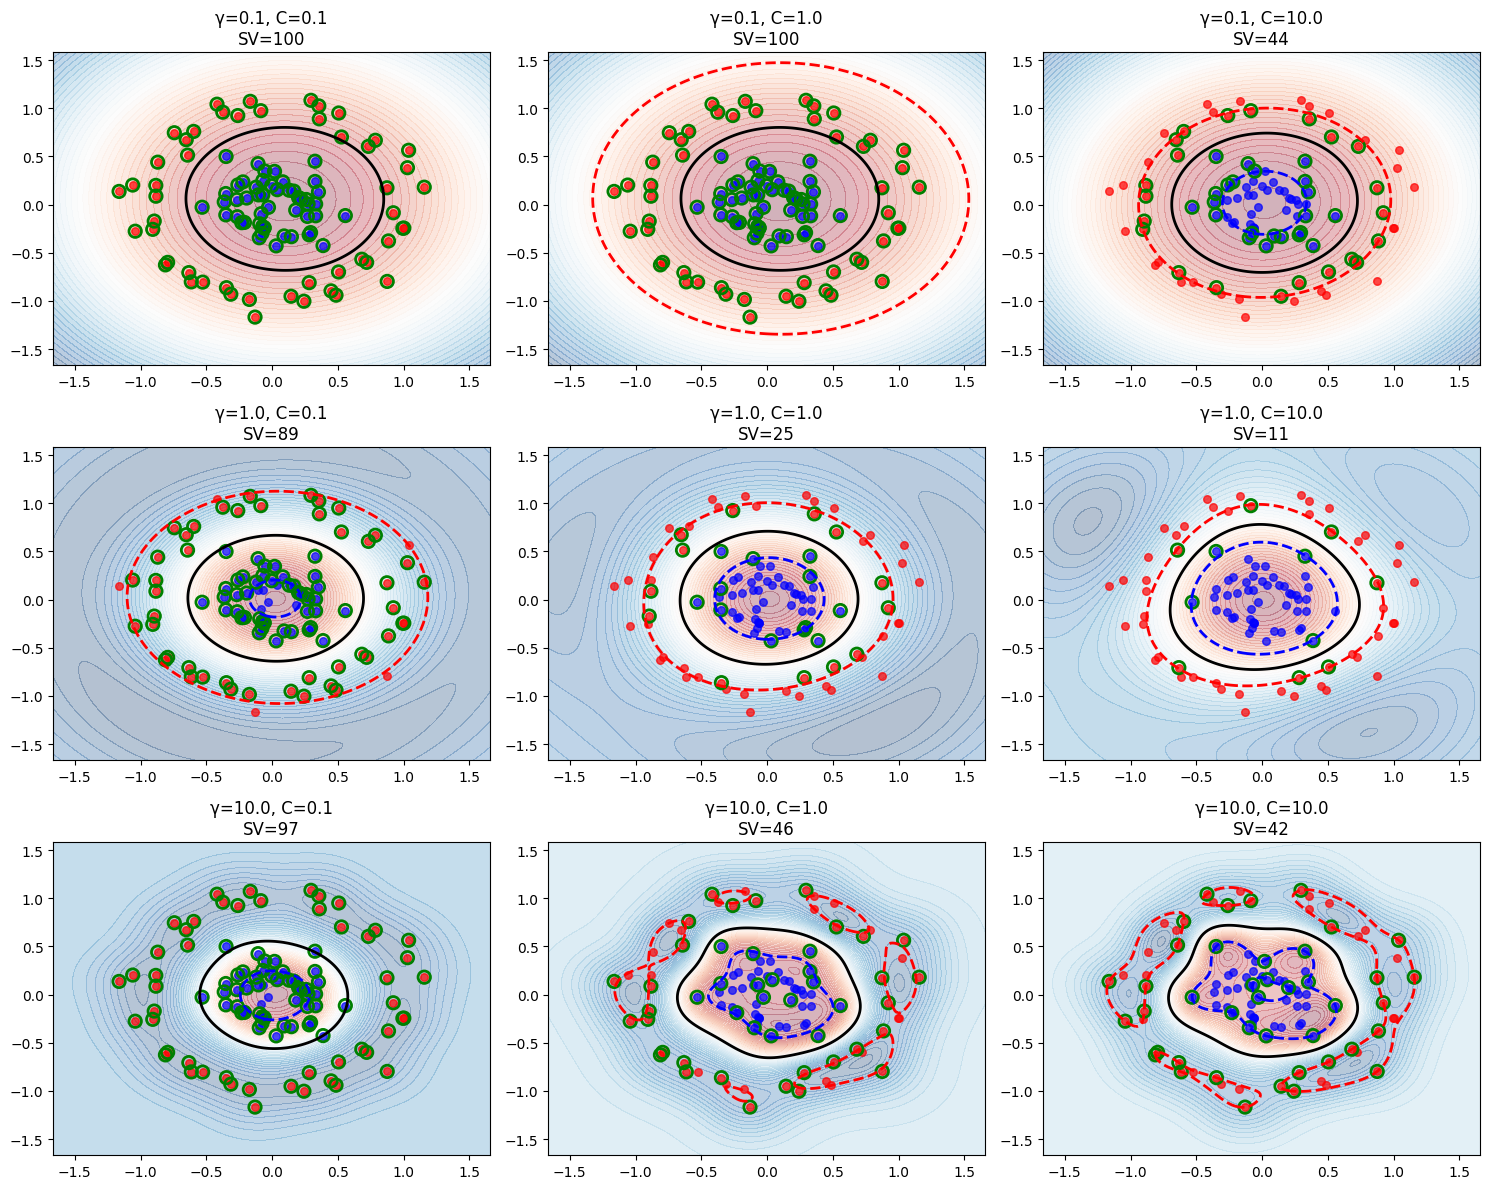

Анализ завершен!


In [66]:
print("\nПункт 4: Анализ SVM с RBF ядром")

# Анализ зависимости от параметров C и γ
gamma_values = [0.1, 1.0, 10.0]

fig, axes = plt.subplots(len(gamma_values), len(C_values), figsize=(15, 12))

for i, gamma in enumerate(gamma_values):
    for j, C in enumerate(C_values):
        svm = KernelSVM(C=C, kernel='rbf', gamma=gamma)
        svm.fit(X_test, y_test)
        
        ax = axes[i, j]
        Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        ax.contour(xx, yy, Z, levels=[-1, 0, 1], 
                  colors=['red', 'black', 'blue'], 
                  linestyles=['--', '-', '--'], linewidths=2)
        ax.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdBu_r')
        ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='blue', alpha=0.7, s=30)
        ax.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], c='red', alpha=0.7, s=30)
        ax.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
                  s=80, facecolors='none', edgecolors='green', linewidths=2)
        
        ax.set_title(f'γ={gamma}, C={C}\nSV={len(svm.support_vectors)}')

plt.tight_layout()
plt.show()

print("Анализ завершен!")

γ = 0.1: Слишком простые границы (недообучение)

γ = 1.0: Сбалансированные гладкие границы

γ = 10.0: Слишком сложные границы (переобучение)

C = 0.1: Устойчивое решение, игнорирует шум

C = 10.0: Чуткое решение, следует за шумом

Переобучение: C > 10, γ > 5;
Недообучение: C < 0.1, γ < 0.1;
Оптимум: C = 0.1-1.0, γ = 0.5-2.0

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [4]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\aeavetisyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\pylab.py:166: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Users\aeavetisyan\AppData\Local\Temp\ipykernel_13952\2390794766.py:16: UserWarning: linewidths is ignored by contourf
  contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')


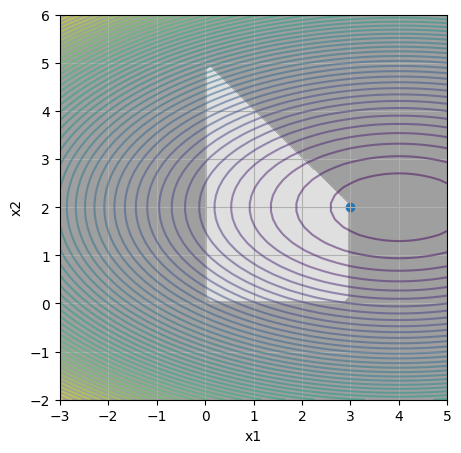

In [5]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [6]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [7]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [8]:
!pip install --upgrade --user cvxopt


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [9]:
from cvxopt import solvers
?solvers.qp

Signature:
solvers.qp(
    P,
    q,
    G=None,
    h=None,
    A=None,
    b=None,
    solver=None,
    kktsolver=None,
    initvals=None,
    **kwargs,
)
Docstring:
Solves a quadratic program

    minimize    (1/2)*x'*P*x + q'*x
    subject to  G*x <= h
                A*x = b.


Input arguments.

    P is a n x n dense or sparse 'd' matrix with the lower triangular
    part of P stored in the lower triangle.  Must be positive
    semidefinite.

    q is an n x 1 dense 'd' matrix.

    G is an m x n dense or sparse 'd' matrix.

    h is an m x 1 dense 'd' matrix.

    A is a p x n dense or sparse 'd' matrix.

    b is a p x 1 dense 'd' matrix or None.

    solver is None or 'mosek'.

    The default values for G, h, A and b are empty matrices with
    zero rows.


Output arguments (default solver).

    Returns a dictionary with keys 'status', 'x', 's', 'y', 'z',
    'primal objective', 'dual objective', 'gap', 'relative gap',
    'primal infeasibility, 'dual infeasibility', 'primal

## Пример работы с cvxopt

In [10]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [11]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [12]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [13]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701755e-06,
 'relative gap': 4.3942774404996174e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 8.740420517429097e-17,
 'dual infeasibility': 3.937229820906071e-16,
 'primal slack': 7.131816408857288e-07,
 'dual slack': 1.5069511036049803e-08,
 'iterations': 8}

In [14]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [15]:
from sklearn.datasets import make_classification

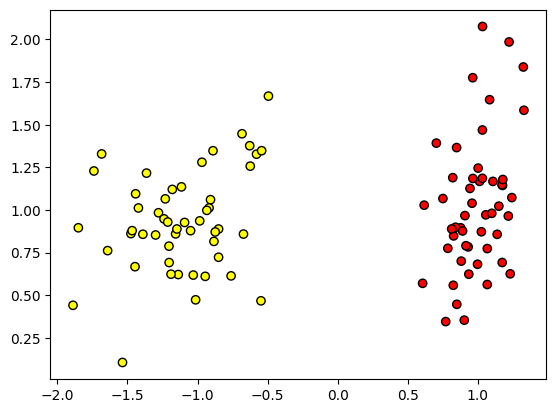

In [16]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

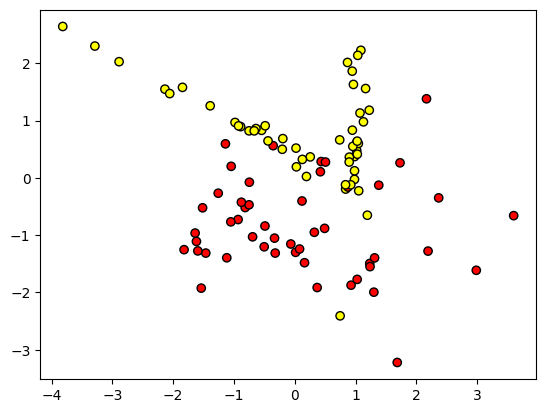

In [17]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

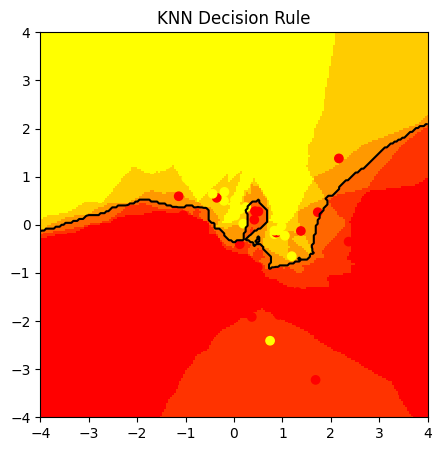

In [18]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [19]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [20]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass